In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/tropics_20d.yaml'

In [3]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = ocean)

Data loaded from /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 2.16 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.00 seconds


/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c
/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


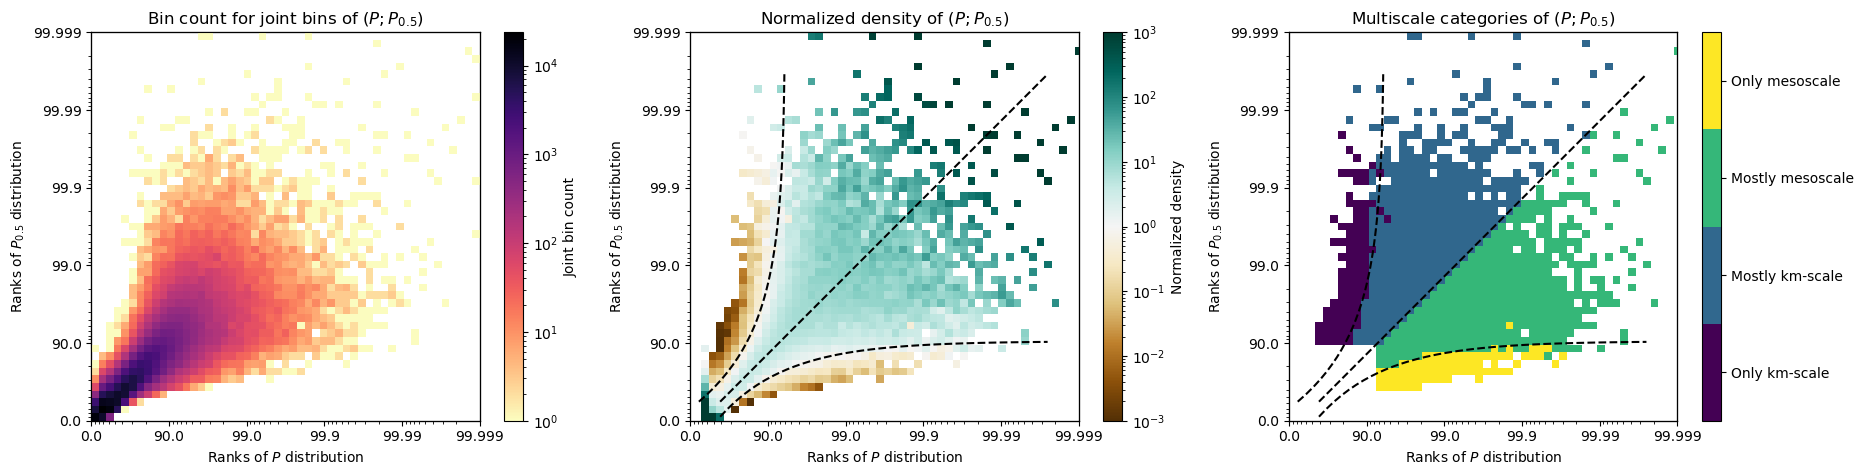

In [4]:
%matplotlib inline
import matplotlib as mpl

# jd =joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = False)

fig, axs = plt.subplots(1, 3, figsize=(3.92*4.8, 4.85))

ax, cb = jd.plot_data(jd.bincount, scale = 'log', label = "Joint bin count", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
ax.set_title(r"Bin count for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.5}$ distribution")

ax, cb = jd.plot(mask = False, branch=True, fig = fig, ax = axs[1])
ax.set_title(r"Normalized density of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.5}$ distribution")

ax, cb = jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
cb.remove()

ax.set_title(r"Multiscale categories of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.5}$ distribution")

values = np.unique([1, 2, 3, 4])
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0.5, 5), cmap.N)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    ax=ax, ticks=values, spacing='proportional')
cbar.set_ticklabels(['Only km-scale', 'Mostly km-scale', 'Mostly mesoscale', 'Only mesoscale'])

fig.tight_layout()
plt.savefig("norm_density.png")

## Bincount map per category

Only km-scale
figure size = 15 3.25
Mostly km-scale
figure size = 15 3.25
Mostly mesoscale
figure size = 15 3.25
Only mesoscale
figure size = 15 3.25


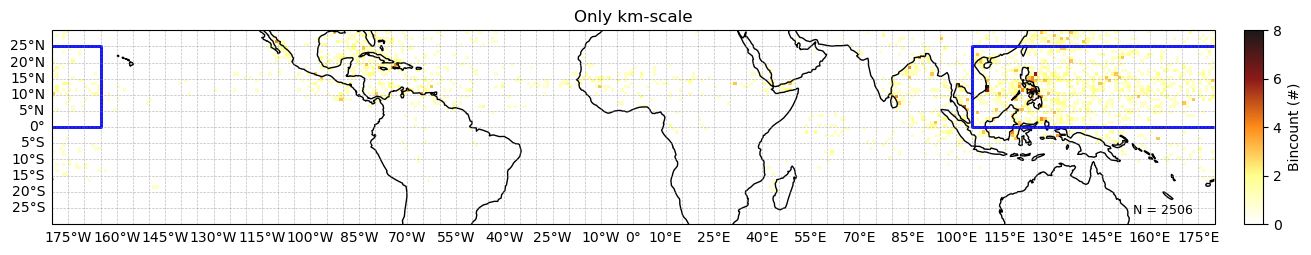

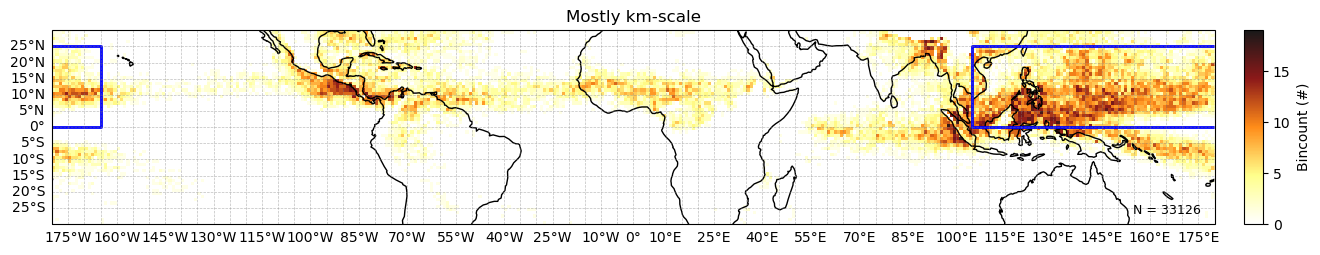

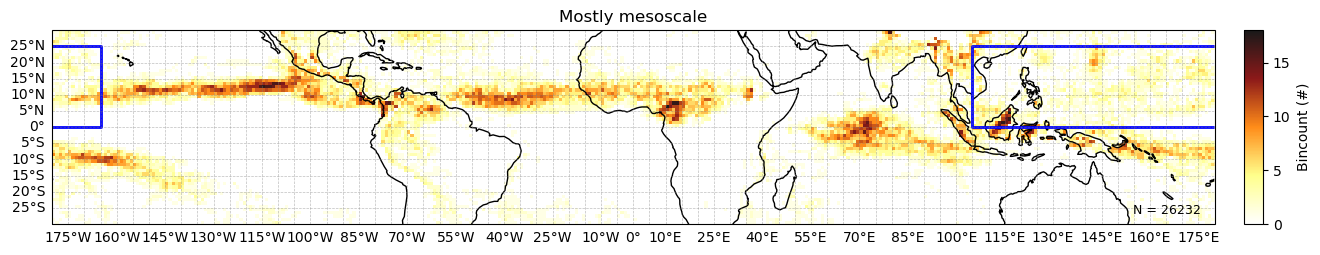

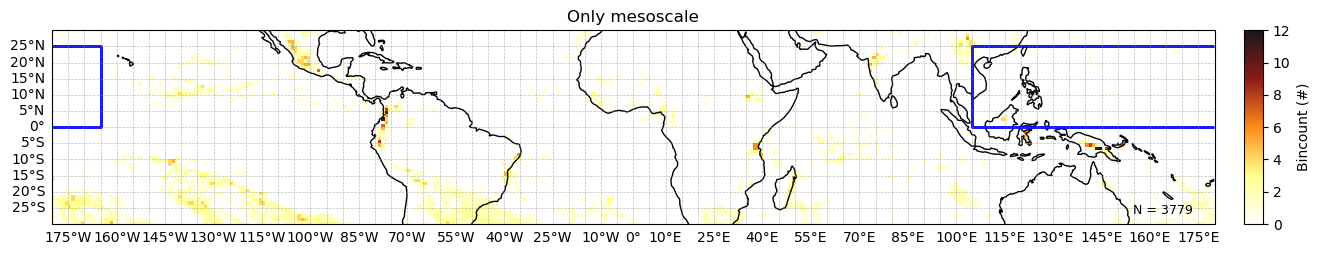

In [16]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Only km-scale','Mostly km-scale','Mostly mesoscale','Only mesoscale'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

# rank  = 2 # 2 , 3,4

# if rank == 1 : 
#     rank_min, rank_max = 90, 99
# elif rank == 2 :
#     rank_min, rank_max = 99, 99.9
# elif rank == 3 :
#     rank_min, rank_max = 99.9, 99.99
# elif rank == 4 :
#     rank_min, rank_max = 99.99, 100

rank_conv_min = 90
rank_acc_min = 90

mask_rank_conv = np.outer(jd.dist1.ranks >= 0, jd.dist2.ranks >= rank_conv_min)
mask_rank_acc = np.outer(jd.dist1.ranks >= rank_acc_min , jd.dist2.ranks >= 0)
            
mask_rank_all = [mask_rank_conv, mask_rank_conv, mask_rank_acc, mask_rank_acc]

for mask,mask_rank, mask_name,mask_label in zip(mask_all,mask_rank_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_ranked = np.logical_and(mask, mask_rank)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask_ranked)
    # mask_yxt = np.logical_and(mask_yxt, ocean)
    ax, cbar = jd.make_map(mask_yxt, data = None)

    # lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
    # lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    # ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
    #             [lat_min, lat_min, lat_max, lat_max, lat_min],
    #             color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
    lon_min, lon_max = 105, 195 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    
    # ax.legend()
    
    ax.set_title(mask_name)

    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')
    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

## Bincount weigthed by threshold per catgeroy

Convective only
figure size = 15 3.25
Mostly convective


figure size = 15 3.25
Mostly mesoscale
figure size = 15 3.25
Mesoscale only
figure size = 15 3.25


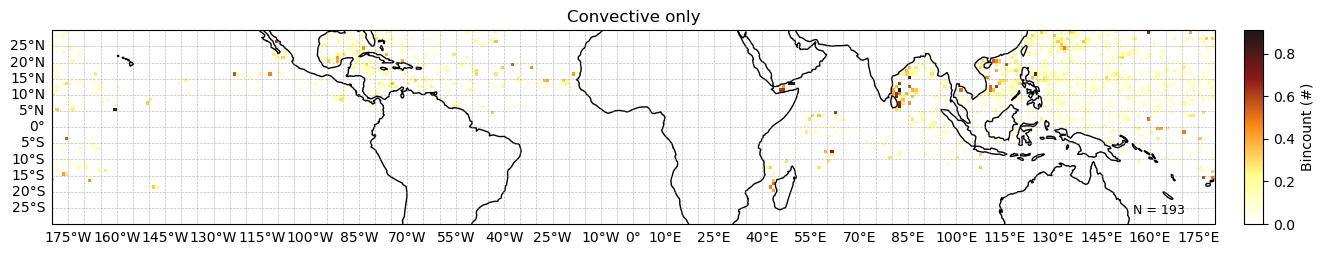

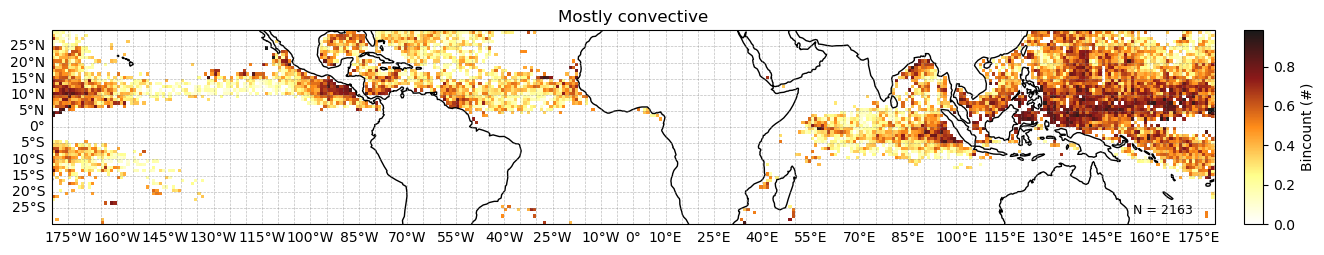

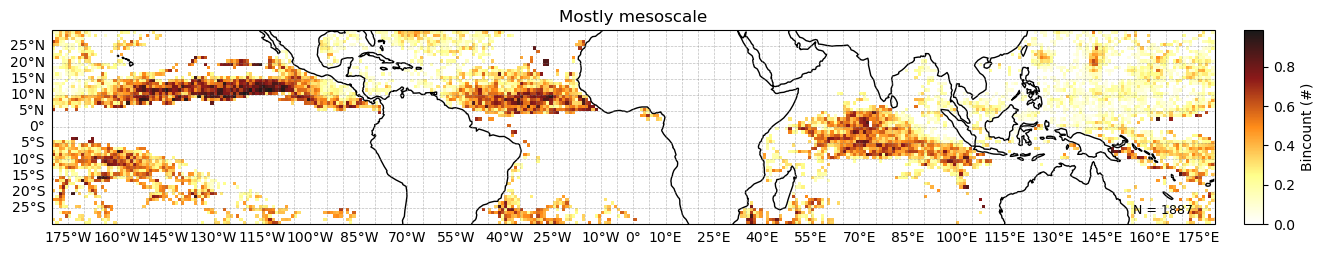

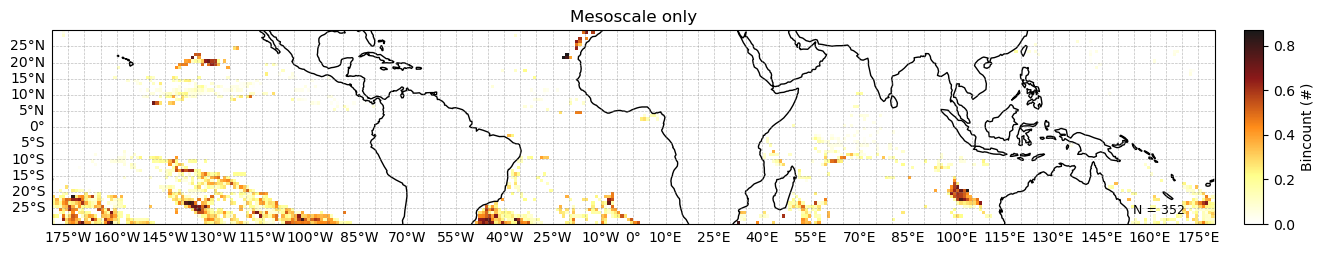

In [6]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

data = jd.prec.Treshold_cond_alpha_50_Prec.values

for mask, mask_name,mask_label in zip(mask_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask)
    mask_yxt_ocean = np.logical_and(mask_yxt, ocean)
    ax, cbar = jd.make_map(mask_yxt_ocean, data = data, func='data_weighted')
    ax.set_title(mask_name)

## Bincount weighted per sigma per category

Convective only
figure size = 15 3.25
Mostly convective


figure size = 15 3.25
Mostly mesoscale
figure size = 15 3.25
Mesoscale only
figure size = 15 3.25


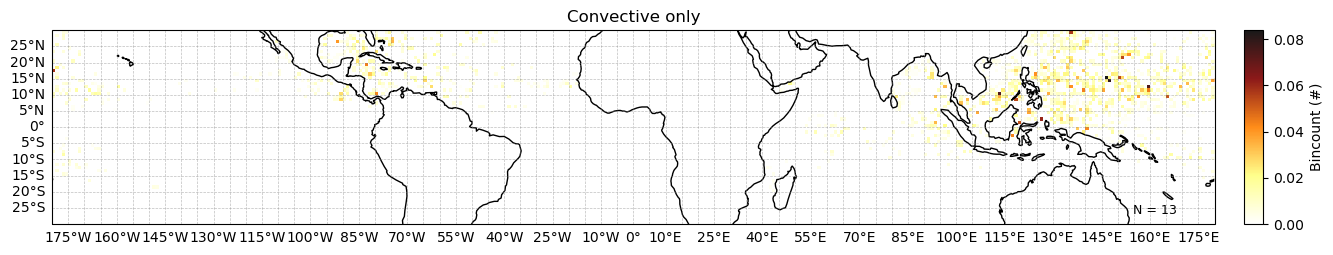

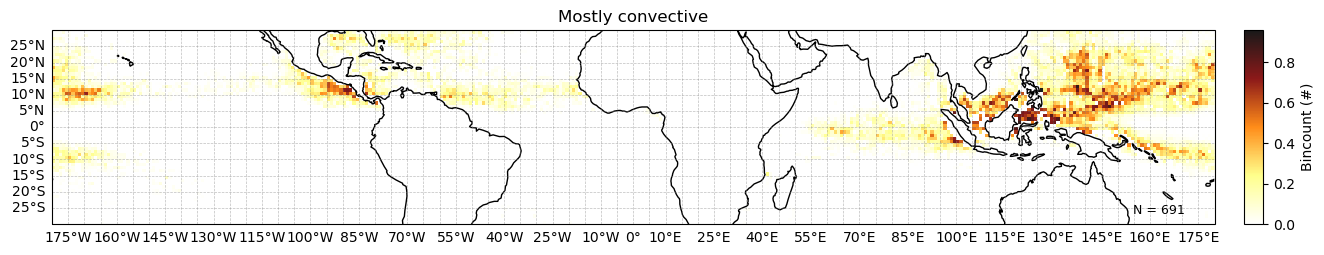

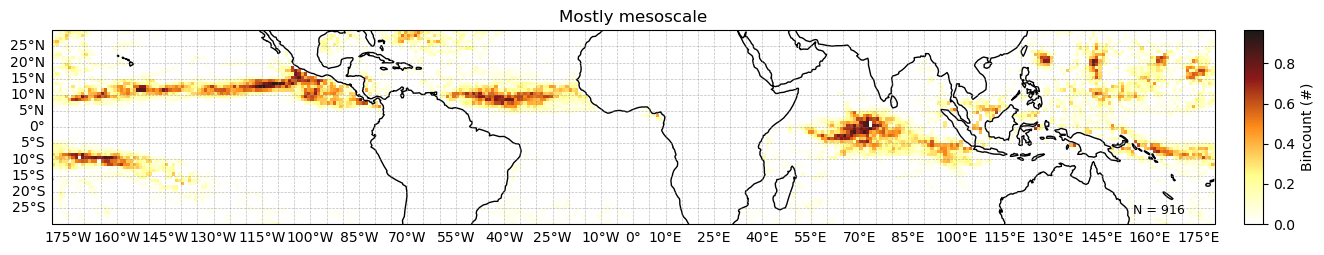

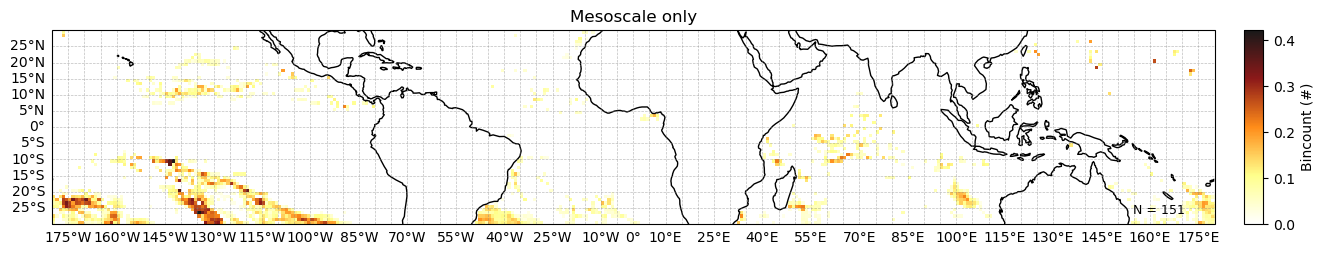

In [7]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

data = jd.prec.Sigma_cond_alpha_50_Prec.values

for mask, mask_name,mask_label in zip(mask_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask)
    mask_yxt_ocean = np.logical_and(mask_yxt, ocean)
    ax, cbar = jd.make_map(mask_yxt_ocean, data = data, func='data_weighted')
    ax.set_title(mask_name)

## Threshld and sigma sums on map 

In [8]:
# # km-scale map threshsold 
# data = jd.prec.Treshold_cond_alpha_50_Prec.values
# ax, cbar = jd.make_map(data, data = None)
# ax.set_title(r"Somme des $p_{0.5}$")
# # coarse-grained map sigma
# data = jd.prec.Sigma_cond_alpha_50_Prec.values
# ax, cbar = jd.make_map(data, data = None)
# ax.set_title(r"Somme des $\sigma_{0.5}$")


## Func that makes region mask

In [9]:
def make_region_mask(min_lat, max_lat, min_lon, max_lon, pre_mask = True):
    array_shape = (60, 360, 20)
    # Combine the masks along each dimension
    mask = np.zeros(array_shape, dtype=bool)
    mask[min_lat+30:max_lat+30, min_lon:max_lon, :] = True
    mask = np.logical_and(mask, pre_mask)
    return mask

warmpool = make_region_mask(0, 25, 125, 185, pre_mask = ocean)
indian_ocean = make_region_mask(-15, 10, 50, 100, pre_mask = ocean)
rest_ocean = np.logical_and(~warmpool, ocean)

## Storms attributes

# QV* 2d

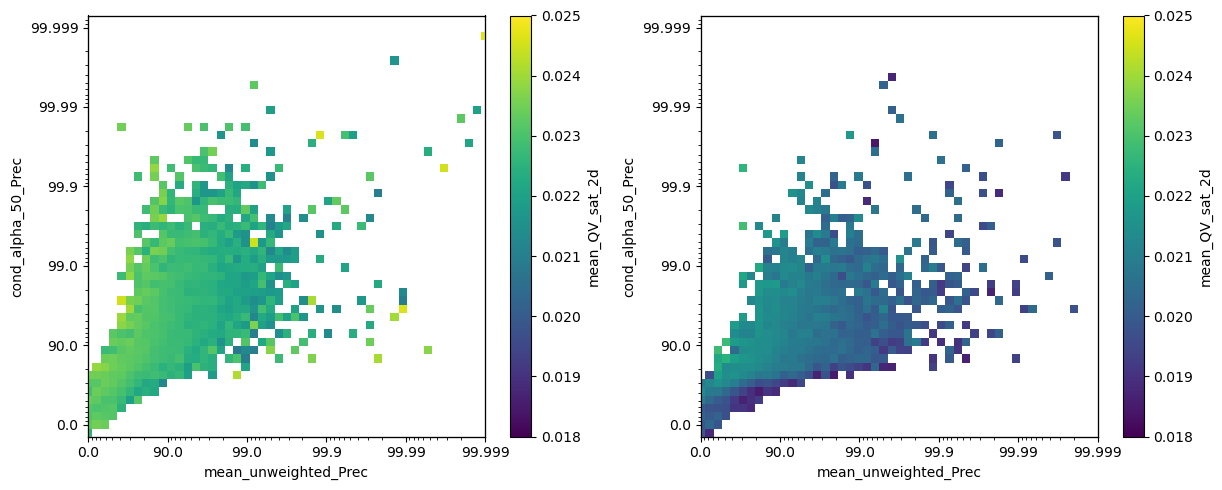

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "QV_sat_2d"
func = 'mean' 
vbds = (0.018, 0.025)
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, vbds = vbds, fig = fig, ax = axs[0])
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = indian_ocean, vbds = vbds, fig = fig, ax = axs[1])
plt.tight_layout()

# T2mm

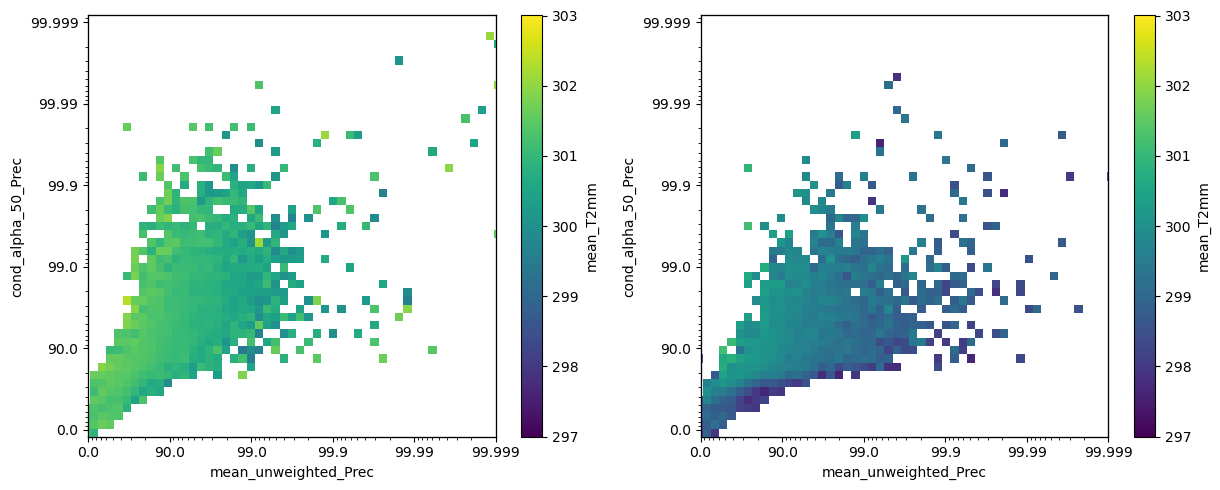

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "T2mm"
func = 'mean' 
vbds = (297, 303)
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, vbds = vbds, fig = fig, ax = axs[0])
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = indian_ocean, vbds= vbds,  fig = fig, ax = axs[1])
plt.tight_layout()

# neg OM 850 cond Prec lag 1

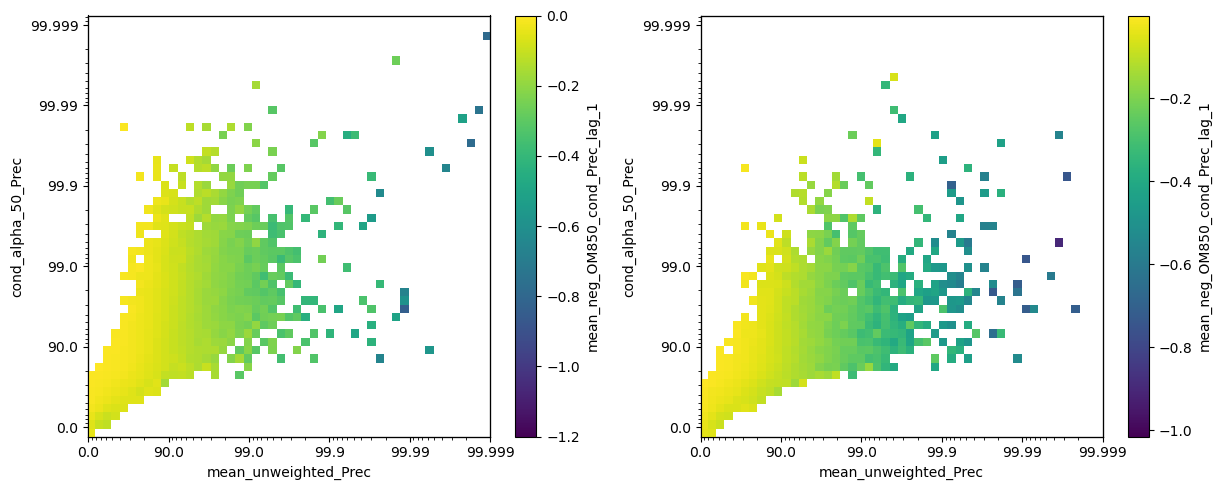

In [12]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "neg_OM850_cond_Prec_lag_1"
func = 'mean' 
vbds = (-1.2, 0)
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, vbds = vbds, fig = fig, ax = axs[0])
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = indian_ocean, fig = fig, ax = axs[1])
plt.tight_layout()

## storm attr from MCS_label.nc

In [13]:
def custom_nan_percentile(arr, q):
    """
    Calculate the q-th percentile of the given array, handling NaN values.

    Parameters:
        arr (array-like): Input array.
        q (float): Percentile to compute (between 0 and 100).

    Returns:
        float: The q-th percentile of the array.
    """
    # Filter out NaN values
    non_nan_values = arr[~np.isnan(arr)]
    
    # Check if there are no non-NaN values
    if len(non_nan_values) == 0:
        return np.nan
    
    # Calculate the percentile
    return np.percentile(non_nan_values, q)

In [14]:
mcs = gr.get_var_id_ds("MCS_label")
mcs

<xarray.Dataset>
Dimensions:                         (lat_global: 60, lon_global: 360, days: 20,
                                     MCS: 300)
Coordinates:
  * lat_global                      (lat_global) float64 -29.5 -28.5 ... 29.5
  * lon_global                      (lon_global) float64 0.5 1.5 ... 358.5 359.5
  * days                            (days) object '16-08-21' ... '16-09-09'
  * MCS                             (MCS) int64 0 1 2 3 4 ... 296 297 298 299
Data variables:
    global_pixel_surf               (lat_global, lon_global, days) float64 ...
    MCS_label                       (lat_global, lon_global, days, MCS) float64 ...
    Rel_surface                     (lat_global, lon_global, days, MCS) float64 ...
    MCS_rel_occupation              (lat_global, lon_global, days) float64 ...
    max_MCS_rel_surf                (lat_global, lon_global, days) float64 ...
    avg_MCS_rel_surf                (lat_global, lon_global, days) float64 ...
    root_weight_avg_MCS_rel_surf    (lat_global, lon_global, days) float64 ...
    square_weight_avg_MCS_rel_surf  (lat_global, lon_global, days) float64 ...
    weight_avg_MCS_rel_surf         (lat_global, lon_global, days) float64 ...
    growth_rate                     (lat_global, lon_global, days) float64 ...
    olrmin_surf_fro_adj             (lat_global, lon_global, days) float64 ...

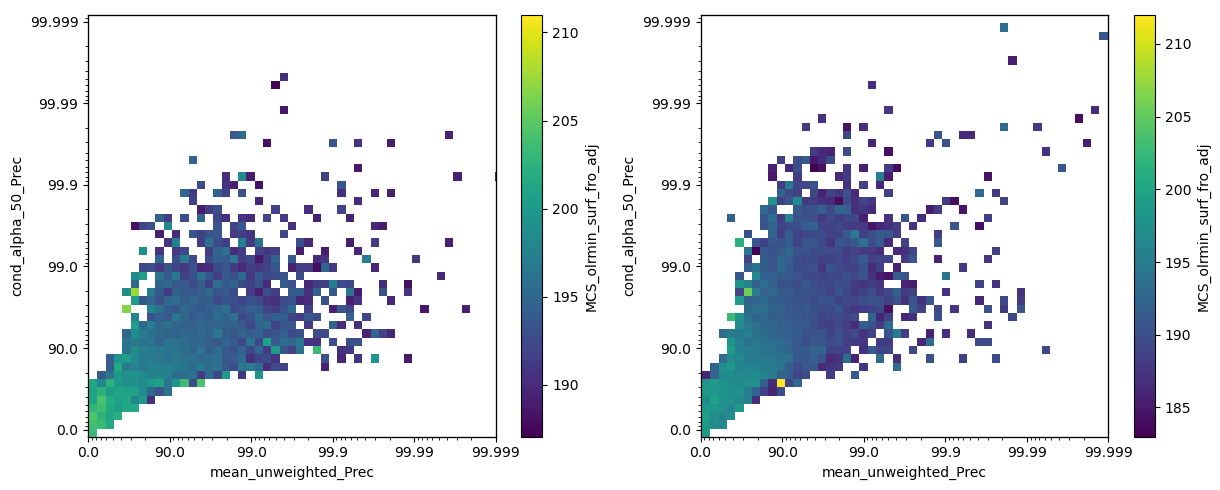

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "olrmin_surf_fro_adj"
func = 'MCS' 
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = indian_ocean, plot_func = lambda x : custom_nan_percentile(x, 10) ,fig = fig, ax = axs[0])
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, plot_func = lambda x : custom_nan_percentile(x, 10), fig = fig, ax = axs[1])
plt.tight_layout()

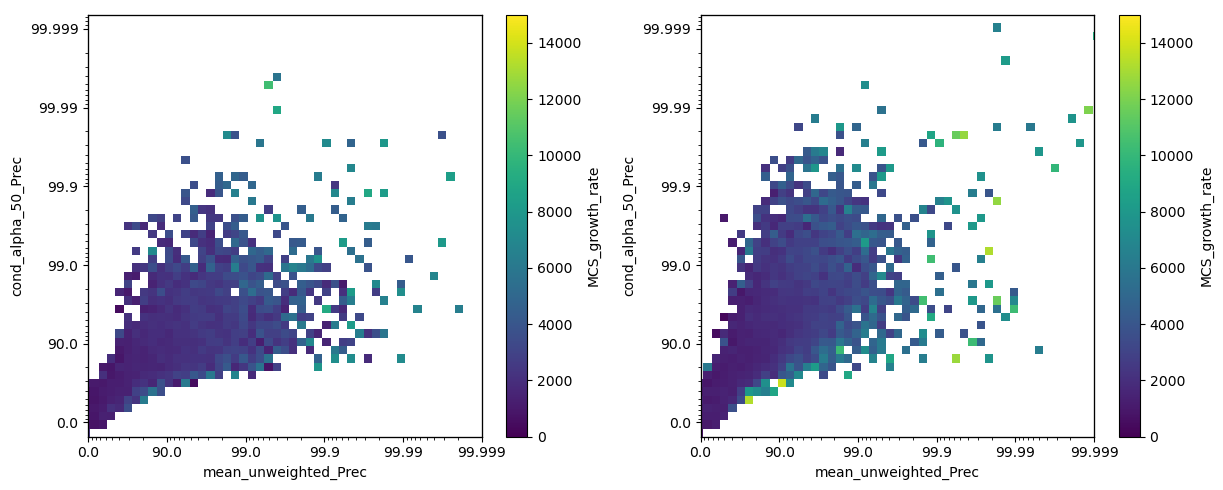

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "growth_rate"
func = 'MCS' 
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = indian_ocean, plot_func = lambda x : custom_nan_percentile(x, 90) ,fig = fig, ax = axs[0], vbds = (0, 15000))
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, plot_func = lambda x : custom_nan_percentile(x, 90), fig = fig, ax = axs[1], vbds = (0, 15000))
plt.tight_layout()

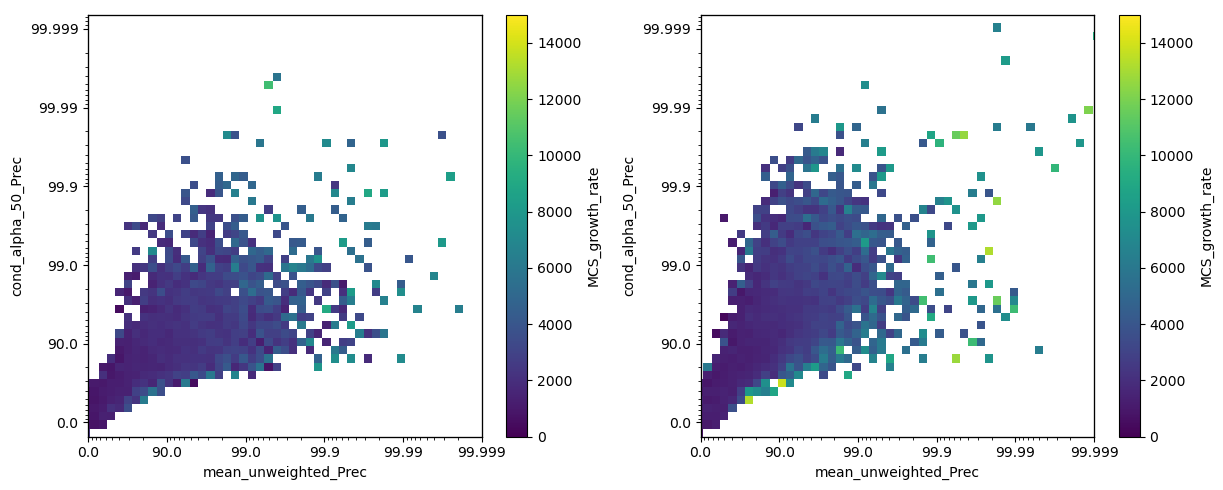

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "growth_rate"
func = 'MCS' 
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = indian_ocean, plot_func = np.nanmean,fig = fig, ax = axs[0], vbds = (0, 15000))
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, plot_func =  np.nanmean, fig = fig, ax = axs[1], vbds = (0, 15000))
plt.tight_layout()

## Norm growth rate

In [23]:
# import xarray as xr
# import os 

# output_file_path = st.file_storms  # Specify your desired output file path here
# ds_storms = xr.open_dataset(output_file_path)
# ds_storms['norm_growth_rate'] = ds_storms['growth_rate'] / ds_storms['s_max']
# ds_storms['norm_growth_rate'] = ds_storms['norm_growth_rate'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1), np.nan)
# ds_storms['norm_growth_rate'] = ds_storms['norm_growth_rate'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1), np.nan)

# os.remove(output_file_path)
# ds_storms.to_netcdf(output_file_path)

## avg, Min OLR_90th 

In [ ]:
%matplotlib inline
def percentile_90(numbers):
    return np.percentile(numbers, 90)
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', np.mean, fast = False, region_mask = ocean)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title('Average in jdist of minimal MCS OLR_90th(t)')
cb.set_label("OLR in name, but certainly K")

In [ ]:
%matplotlib inline
def frac_under_threshold(numbers, threshold):
    return np.sum(numbers < threshold)/len(numbers)

t_b = 200
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', lambda x: frac_under_threshold(x, t_b) , fast = False, region_mask = ocean)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title(f'Fraction of bins with a MCS deeper than {t_b}K in oceans')
cb.set_label("OLR in name, but certainly K")

In [ ]:
%matplotlib inline
def frac_under_threshold(numbers, threshold):
    return np.sum(numbers < threshold)/len(numbers)

t_b = 200
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', lambda x: frac_under_threshold(x, t_b) , fast = False, region_mask = warmpool)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title(f'Fraction of bins with a MCS deeper than {t_b}K in warm pool')
cb.set_label("OLR in name, but certainly K")

In [ ]:
%matplotlib inline
def frac_under_threshold(numbers, threshold):
    return np.sum(numbers < threshold)/len(numbers)

t_b = 200
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', lambda x: frac_under_threshold(x, t_b) , fast = False, region_mask = indian_ocean)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title(f'Fraction of bins with a MCS deeper than {t_b}K in indian ocean')
cb.set_label("OLR in name, but certainly K")

## Made some new attributes for storms here TODO : put it in ds_storms overwirte = True compartiment

In [14]:
storms = xr.open_dataset(jd.file_storms, mode='r')
storms["min_olr_90th"] = storms.olr_90th.min(dim = 'time', skipna = True)

In [21]:
storms

<xarray.Dataset>
Dimensions:              (label: 118704, time: 960)
Coordinates:
  * label                (label) int64 134375 134380 134382 ... 304339 304343
  * time                 (time) int64 960 961 962 963 ... 1916 1917 1918 1919
Data variables: (12/71)
    Tmax                 (label) float64 ...
    Utime_End            (label) float64 ...
    Utime_Init           (label) float64 ...
    classif              (label) int64 ...
    classif_JIRAK        (label) float64 ...
    dist                 (label) float64 ...
    ...                   ...
    decay_r_squared      (label) float64 ...
    t0                   (label) float64 ...
    t_max                (label) float64 ...
    t_f                  (label) float64 ...
    s_max                (label) float64 ...
    min_olr_90th         (label) float64 217.3 190.8 191.5 ... 224.1 226.9 228.6

In [22]:
jd.add_mcs_var_from_labels("olrmin", norm_rel_surf = 'fro')

In [25]:
os.remove(jd.file_storms)
storms.to_netcdf(jd.file_storms)
storms.close()

## test day variance

In [ ]:
# Create a 5x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for i, ax in enumerate(axes.flatten()):
    # Copy the original mask to avoid modifying it directly
    modified_mask = np.copy(indian_ocean)

    num_days = modified_mask.shape[2]

    days_mask = np.zeros(num_days, dtype = bool)
    days_mask[i] = True
    # Set the ith slice to False
    modified_mask[:, :, ~days_mask] = False

    # Generate the storm attribute data using the modified mask
    # This is a conceptual call, replace it with the actual function call you have
    storm_var = jd.storm_attributes_on_jdist('min_olr_90th', np.mean, fast=False, region_mask=modified_mask)

    # Plot the data on the current subplot
    ax, cb = jd.plot_data(storm_var, cmap = 'viridis', fig = fig, ax = ax, cb_bool = True)
    ax.set_title(f'Subplot {i}')
    
plt.show()
plt.tight_layout()